In [113]:
#Data read, prepare packages
#PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from copy import deepcopy
import subprocess as sp

In [ ]:
#TensorFlow packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp
import subprocess as sp
import fileinput as fi
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import pickle
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import linecache

print(tf.__version__)

## Functions definitions

In [24]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype('float32'))
    timeStepsList = timeStepsList[index]
    return list(timeStepsList)

In [25]:
def readFile(filename, sz):
    res = []
    data = pd.read_csv(filename, header=None, skiprows=23, nrows=sz, dtype=str)
    data = data.iloc[:, 0].str.replace('[(,)]', '', regex=True)
    for row in data:
        row = row.split()
        data = []
        for val in row:
            data.append(float(val))
        res.append(data)
    return np.array(res)

In [26]:
def readTime(time, sz):
    folder = f'TPF/cfd/{time}/'
    IsRes = [readFile(folder+filename, sz) for filename in [f'I{i}' for i in range(5)]]
    TsRes = [readFile(folder+filename, sz) for filename in [f'T{i}' for i in range(10)]]
    URes = readFile(folder + 'U', sz)
    pRes = readFile(folder + 'p', sz)
    #gradPRes = readFile(folder + 'gradP', sz)
    #gradURes = readFile(folder + 'gradU', sz)
    inv1GradURes = readFile(folder + 'inv1GradU', sz)
    inv2GradURes = readFile(folder + 'inv2GradU', sz)
    magGradPRes = readFile(folder + 'magGradP', sz)
    rotationRateTensorRes = readFile(folder + 'rotationRateTensor', sz)
    strainRateTensorRes = readFile(folder + 'strainRateTensor', sz)
    folder = f'TPF/{time}/'
    URef = readFile(folder + 'U', sz)
    pRef = readFile(folder + 'p', sz)
    return IsRes, TsRes, URes, pRes, inv1GradURes, inv2GradURes, magGradPRes, \
        rotationRateTensorRes, strainRateTensorRes, URef, pRef
#pRef = np.concatenate([readFile(folder + 'p', sz) for folder in foldersRef], axis=0)

#%%time

#IsRes, TsRes, URes, pRes, inv1GradURes, inv2GradURes, magGradPRes, \
#        rotationRateTensorRes, strainRateTensorRes, URef, pRef = readTime(time, sz)
#URes

In [35]:
#def formDataset(*args, scaler):
#    return Variable(torch.tensor(scaler.transform(np.concatenate(args, axis=1))).type(torch.FloatTensor),\
#                    requires_grad=True)
def formDataset(*args):
    return Variable(torch.tensor(np.concatenate(args, axis=1)).type(torch.FloatTensor),\
                    requires_grad=True)

In [74]:
def writePrediction(Pred, folder, time, sz):
    sp.call('mkdir -p TPF/'+folder+f'/{time}/', shell=True)
    with open(f'TPF/{time}/U','r') as firstfile, open('TPF/'+folder+f'/{time}/U','w') as secondfile: 
        for line in firstfile.readlines()[:23]:
            secondfile.write(line)
    with open(f'TPF/{time}/p','r') as firstfile, open('TPF/'+folder+f'/{time}/p','w') as secondfile: 
        for line in firstfile.readlines()[:23]:
            secondfile.write(line)
    with open('TPF/'+folder+f'/{time}/U','a') as fU, open('TPF/'+folder+f'/{time}/p','a') as fp:
        for val in Pred:
            fU.write(f'({val[0].item()} {val[1].item()} {val[2].item()})\n')
            fp.write(f'{val[3].item()}\n')
    with open(f'TPF/{time}/U','r') as firstfile, open('TPF/'+folder+f'/{time}/U','a') as secondfile: 
        for line in firstfile.readlines()[sz+23:]:
            secondfile.write(line)
    with open(f'TPF/{time}/p','r') as firstfile, open('TPF/'+folder+f'/{time}/p','a') as secondfile: 
        for line in firstfile.readlines()[sz+23:]:
            secondfile.write(line)

## Data operations

In [30]:
times = timeStepsList()[2:6]

In [64]:
with open(f'TPF/{times[0]}/U','r') as file:
    sz = int(file.readlines()[21])

49800

In [165]:
#Read data
%%time

foldersRes = [f'TPF/cfd/{time}/' for time in times]
foldersRef = [f'TPF/{time}/' for time in times]
    
IsRes = [np.concatenate([readFile(folder+filename, sz) for folder in foldersRes], axis=0) \
         for filename in [f'I{i}' for i in range(5)]]
TsRes = [np.concatenate([readFile(folder+filename, sz) for folder in foldersRes], axis=0) \
         for filename in [f'T{i}' for i in range(10)]]
URes = np.concatenate([readFile(folder + 'U', sz) for folder in foldersRes], axis=0)
pRes = np.concatenate([readFile(folder + 'p', sz) for folder in foldersRes], axis=0)
gradPRes = np.concatenate([readFile(folder + 'gradP', sz) for folder in foldersRes], axis=0)
gradURes = np.concatenate([readFile(folder + 'gradU', sz) for folder in foldersRes], axis=0)
inv1GradURes = np.concatenate([readFile(folder + 'inv1GradU', sz) for folder in foldersRes], axis=0)
inv2GradURes = np.concatenate([readFile(folder + 'inv2GradU', sz) for folder in foldersRes], axis=0)
magGradPRes = np.concatenate([readFile(folder + 'magGradP', sz) for folder in foldersRes], axis=0)
rotationRateTensorRes = np.concatenate([readFile(folder + 'rotationRateTensor', sz) for folder in foldersRes], \
                                       axis=0)
strainRateTensorRes = np.concatenate([readFile(folder + 'strainRateTensor', sz) for folder in foldersRes], \
                                     axis=0)

URef = np.concatenate([readFile(folder + 'U', sz) for folder in foldersRef], axis=0)
pRef = np.concatenate([readFile(folder + 'p', sz) for folder in foldersRef], axis=0)

CPU times: user 20.6 s, sys: 638 ms, total: 21.3 s
Wall time: 21.7 s


In [166]:
#Data preparation
for i in range(len(times)):
    for j in range(5):
        IsRes[j][i*sz:(i+1)*sz] = IsRes[j][i*sz:(i+1)*sz] - np.mean(IsRes[j][i*sz:(i+1)*sz])
    for j in range(10):
        for k in range(9):
            TsRes[j][i*sz:(i+1)*sz].T[k] = TsRes[j][i*sz:(i+1)*sz].T[k] - np.mean(TsRes[j][i*sz:(i+1)*sz].T[k])
    for j in range(3):
        URes[i*sz:(i+1)*sz].T[j] = URes[i*sz:(i+1)*sz].T[j] - np.mean(URes[i*sz:(i+1)*sz].T[j])
    pRes[i*sz:(i+1)*sz] = pRes[i*sz:(i+1)*sz] - np.mean(pRes[i*sz:(i+1)*sz])
    for j in range(3):
        gradPRes[i*sz:(i+1)*sz].T[j] = gradPRes[i*sz:(i+1)*sz].T[j] - np.mean(gradPRes[i*sz:(i+1)*sz].T[j])
    for j in range(9):
        gradURes[i*sz:(i+1)*sz].T[j] = gradURes[i*sz:(i+1)*sz].T[j] - np.mean(gradURes[i*sz:(i+1)*sz].T[j])
    inv1GradURes[i*sz:(i+1)*sz] = inv1GradURes[i*sz:(i+1)*sz] - np.mean(inv1GradURes[i*sz:(i+1)*sz])
    inv2GradURes[i*sz:(i+1)*sz] = inv2GradURes[i*sz:(i+1)*sz] - np.mean(inv2GradURes[i*sz:(i+1)*sz])
    magGradPRes[i*sz:(i+1)*sz] = magGradPRes[i*sz:(i+1)*sz] - np.mean(magGradPRes[i*sz:(i+1)*sz])
    for j in range(3):
        URef[i*sz:(i+1)*sz].T[j] = URef[i*sz:(i+1)*sz].T[j] - np.mean(URef[i*sz:(i+1)*sz].T[j])
    for k in range(9):
        rotationRateTensorRes[i*sz:(i+1)*sz].T[k] = rotationRateTensorRes[i*sz:(i+1)*sz].T[k] - \
        np.mean(rotationRateTensorRes[i*sz:(i+1)*sz].T[k])
    for k in range(6):
        strainRateTensorRes[i*sz:(i+1)*sz].T[k] = strainRateTensorRes[i*sz:(i+1)*sz].T[k] - \
        np.mean(strainRateTensorRes[i*sz:(i+1)*sz].T[k])   
    pRef[i*sz:(i+1)*sz] = pRef[i*sz:(i+1)*sz] - np.mean(pRef[i*sz:(i+1)*sz])
    
magURes = np.sqrt(URes.T[0]**2+URes.T[1]**2+URes.T[2]**2)
magURes = magURes.reshape([magURes.shape[0], 1])
      
#[IsRes[i*sz:(i+1)*sz].T[i] = IsRes[i*sz:(i+1)*sz].T[i] - np.mean(IsRes[i*sz:(i+1)*sz].T[i]) \
# for i in range(5)]

## PyTorch NN which is now generating random numbers

scaler = MinMaxScaler()
scaler.fit()

In [45]:
nonTensorInput = formDataset(*IsRes, pRes, magURes, inv1GradURes, inv2GradURes, magGradPRes)
tensorInput = formDataset(*TsRes)

In [80]:
target = Variable(torch.tensor(np.concatenate((URef, pRef), axis=1) - \
                               np.concatenate((URes, pRes), axis=1)).type(torch.FloatTensor), \
                  requires_grad=True)

In [84]:
target[:sz].shape

torch.Size([49800, 4])

In [81]:
writePrediction(target[:sz], 'target', times[0], sz)

In [108]:
class TBNN(nn.Module):
    
    def __init__(self, tensorInputLen, nonTensorInputLen, hiddenLayerNeurons=32):
        super(TBNN, self).__init__()
        self.nonTensorInputLen = nonTensorInputLen
        self.tensorInputLen = tensorInputLen
        self.hiddenLayerNeurons = hiddenLayerNeurons
        self.norm = nn.LayerNorm(self.nonTensorInputLen)
        self.fc1 = nn.Linear(self.nonTensorInputLen, self.hiddenLayerNeurons, dtype=torch.float32)
        self.fc2 = nn.Linear(self.hiddenLayerNeurons, self.hiddenLayerNeurons, dtype=torch.float32)
        self.fc3 = nn.Linear(self.hiddenLayerNeurons, self.tensorInputLen, dtype=torch.float32)
        self.fc4 = nn.Bilinear(self.tensorInputLen, self.tensorInputLen, 4)
        
    def forward(self, x1, x2):
        x = self.norm(x1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        #x = self.fc1(x1)
        #x = self.fc2(x)
        #x = self.fc3(x)
        x = self.fc4(x, x2)
        return x

In [109]:
def fit(model, optimizer, criterion, x1, x2, y, test_size=0.01, train=True, shuffle=True, batch_size=100):

    assert len(x1) == len(x2) == len(y)
    
    x1train, x1test, x2train, x2test, ytrain, ytest = train_test_split(x1, x2, y, shuffle=shuffle, test_size=test_size)
    
    model.train(train)                                            # важно для Dropout, BatchNorm
    sumLtrain, Ltest, numB = 0, 0, int(len(x1train)/batch_size)   # ошибка, количество батчей
       
    for i in range(0, numB*batch_size, batch_size):          
        x1b = x1train[i: i+batch_size]                            # текущий батч,
        x2b = x2train[i: i+batch_size]
        yb = ytrain[i: i+batch_size]                              # x1, x2, y - torch тензоры
        
        y_ = model(x1b, x2b)                                      # прямое распространение
        L = criterion(y_, yb)                                     # вычисляем ошибку
  
        if train:                                                 # в режиме обучения
            optimizer.zero_grad()                                 # обнуляем градиенты        
            L.backward(retain_graph=True)                         # вычисляем градиенты            
            optimizer.step()                                      # подправляем параметры
            scheduler.step()
                                     
        sumLtrain += L.item()                                     # суммарная ошибка (item из графа)
         
    model.train(False)
    Ltest = criterion(model(x1test, x2test), ytest).item()
    
    if train:
        scheduler.step()
            
    return sumLtrain/numB, Ltest                                  # средняя ошибка

In [110]:
model = TBNN(len(tensorInput[0]), len(nonTensorInput[0]), hiddenLayerNeurons=32)

In [129]:
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.L1Loss()
optimizer, criterion

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 L1Loss())

In [130]:
epochs = 100

In [131]:
lossesTrain, lossesTest = [], []
for epoch in tqdm(range(epochs)):
    lTrain, lTest = fit(model, optimizer, criterion, nonTensorInput, tensorInput, target, batch_size=5000)
    lossesTrain.append(lTrain)
    lossesTest.append(lTest)

  0%|          | 0/100 [00:00<?, ?it/s]

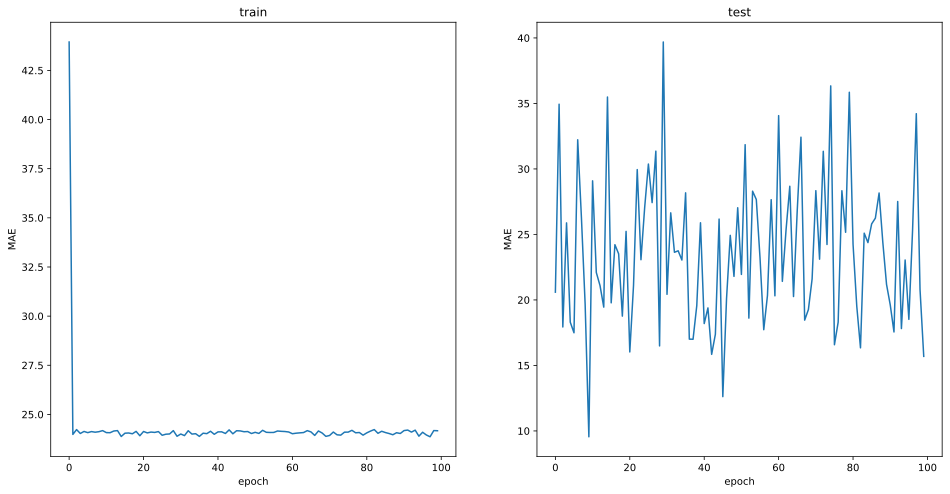

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(list(range(len(lossesTrain))), lossesTrain)
ax[1].plot(list(range(len(lossesTest))), lossesTest)
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].set_ylabel("MAE")
ax[1].set_ylabel("MAE")
plt.show()

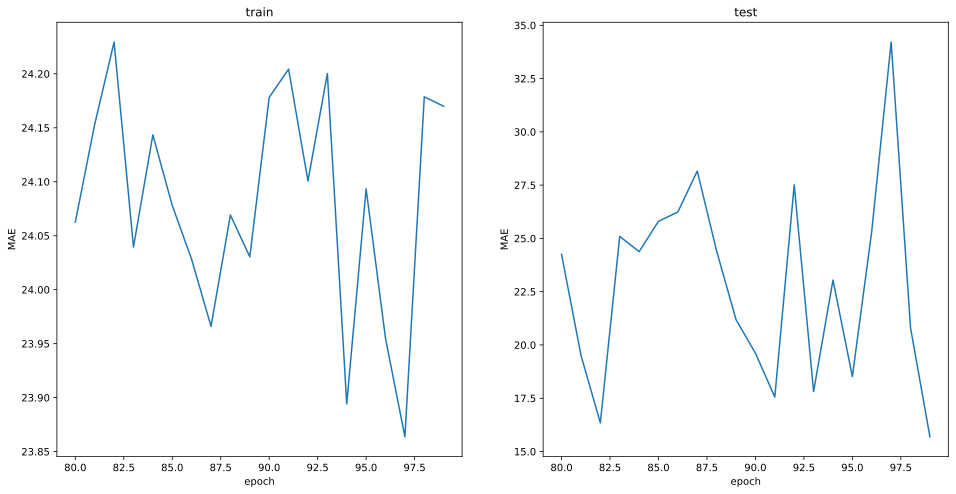

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(list(range(len(lossesTrain)))[80:], lossesTrain[80:])
ax[1].plot(list(range(len(lossesTest)))[80:], lossesTest[80:])
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].set_ylabel("MAE")
ax[1].set_ylabel("MAE")
plt.show()

In [59]:
# for key, val in losses.items():
#     print(min(val))
min(lossesTrain), min(lossesTest)

(nan, nan)

In [125]:
#writePredict(model(nonTensorInput, tensorInput), 'TPF150.1/pred/')
writePrediction(model(nonTensorInput[:sz], tensorInput[:sz]), 'pred', times[0], sz)

In [ ]:
with open('tbnn.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
tracedTBNN = torch.jit.trace(model, example_kwarg_inputs={'x1':torch.randn(9), 'x2':torch.randn(90)})
torch.jit.save(tracedTBNN, "tracedTBNN.pt")

## Tensorflow NN

In [136]:
def formDatasetT(*args):
    return np.concatenate(args, axis=1)

In [169]:
train_features_long = formDatasetT(*IsRes, pRes, magURes, inv1GradURes, inv2GradURes, magGradPRes)
train_features_short = formDatasetT(*TsRes, URes, gradPRes, gradURes, rotationRateTensorRes, strainRateTensorRes)

train_target = np.concatenate((URef, pRef), axis=1) - np.concatenate((URes, pRes), axis=1)

In [170]:
test_features_long = train_features_long[3*sz:]
test_features_short = train_features_short[3*sz:]
test_target = train_target[3*sz:]

train_features_long = train_features_long[:3*sz]
train_features_short = train_features_short[:3*sz]
train_target = train_target[:3*sz]

In [171]:
def compile_and_fitTBNN(model,
                        max_epochs=100,
                        initial_learning_rate=1.0,
                        decay_step=100.0,
                        loss='mean_absolute_error'):
    
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate, decay_step, 1)
    
    metrics_list=[]
    if loss=='mean_absolute_error':
        metrics_list=[loss]
    else:
        metrics_list=[loss, 'mean_absolute_error']
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn),
        loss=loss,
        metrics=metrics_list)
    
    history = model.fit(
        [train_features_long, train_features_short],
        train_target,
        epochs=max_epochs,
        # Suppress logging.
        verbose=0,
        # Calculate validation results on 1% of the training data.
        validation_split = 0.6)
    
    return history

In [172]:
normalizer_tensors = tf.keras.layers.Normalization(axis=-1, name='tensorInputNormalization')
normalizer_tensors.adapt(train_features_short)
normalizer_no_tensors = tf.keras.layers.Normalization(axis=-1, name='generalInputNormalization')
normalizer_no_tensors.adapt(train_features_long)
#normalizer_all = tf.keras.layers.Normalization(axis=-1)
#normalizer_all.adapt(train_features)

In [173]:
inputs_long = keras.Input(shape=(len(train_features_long[0]),), name='generalInput')
inputs_short = keras.Input(shape=(len(train_features_short[0]),), name='tensorInput')
norm_long = normalizer_no_tensors(inputs_long)
norm_short = normalizer_tensors(inputs_short)
denseLayer1 = layers.Dense(64,
                           activation='linear',
                           kernel_initializer=tf.keras.initializers.Ones(),
                           bias_initializer=tf.keras.initializers.Ones(),
                           name='1stDenseLayer')(norm_long)
denseLayer2 = layers.Dense(len(train_features_short[0]),
                           activation='linear',
                           kernel_initializer=tf.keras.initializers.Ones(),
                           bias_initializer=tf.keras.initializers.Ones(),
                           name='2ndDenseLayer')(denseLayer1)
concatenate = layers.Concatenate(name='concatenationLayer')([denseLayer2, norm_short])
outputs = layers.Dense(len(train_target[0]),
                       activation='linear',
                       kernel_initializer=tf.keras.initializers.Ones(),
                       bias_initializer=tf.keras.initializers.Ones(),
                       name='output')(concatenate)

TBNNModel2Concat = keras.Model(
    inputs=[inputs_long, inputs_short],
    outputs=outputs,
)

In [ ]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Visualization tools for tensorflow_docs.

Use this module for plotting and visualization code that is too long to inline
into a notebook.
"""
import matplotlib.pyplot as plt
import numpy as np

prop_cycle = plt.rcParams['axes.prop_cycle']
#COLOR_CYCLE = prop_cycle.by_key()['color']
COLOR_CYCLE=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
             '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
             '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
             '#17becf', '#9edae5']

def _smooth(values, std):
    """Smooths a list of values by convolving with a Gaussian distribution.

    Assumes equal spacing.

    Args:
        values: A 1D array of values to smooth.
        std: The standard deviation of the Gaussian distribution. The units are
            array elements.

    Returns:
        The smoothed array.
    """
    width = std * 4
    x = np.linspace(-width, width, min(2 * width + 1, len(values)))
    kernel = np.exp(-(x / 5)**2)

    values = np.array(values)
    weights = np.ones_like(values)

    smoothed_values = np.convolve(values, kernel, mode='same')
    smoothed_weights = np.convolve(weights, kernel, mode='same')

    return smoothed_values / smoothed_weights


class HistoryPlotter(object):
    """A class for plotting a named set of Keras-histories.

    The class maintains colors for each key from plot to plot.
    """

    def __init__(self, metric=None, smoothing_std=None):
        self.color_table = {}
        self.metric = metric
        self.smoothing_std = smoothing_std

    def plot(self, histories, metric=None, smoothing_std=None, yMin=0, yMax=0, log=False):
        """Plots a {name: history} dictionary of Keras histories.

        Colors are assigned to the name-key, and maintained from call to call.
        Training metrics are shown as a solid line, validation metrics dashed.

        Args:
            histories: {name: history} a dictionary of Keras histories.
            metric: which metric to plot from all the histories.
            smoothing_std: the standard deviation of the smoothing kernel applied
                before plotting. The units are in array-indices.
        """
        if metric is None:
            metric = self.metric
        if smoothing_std is None:
            smoothing_std = self.smoothing_std

        yAv = np.empty(0)
        yL = np.empty(0)
        
        for name, history in histories.items():
            # Remember name->color associations.
            if name in self.color_table:
                color = self.color_table[name]
            else:
                color = COLOR_CYCLE[len(self.color_table) % len(COLOR_CYCLE)]
                self.color_table[name] = color

            train_value = history.history[metric]
            if smoothing_std is not None:
                train_value = _smooth(train_value, std=smoothing_std)

            plt.plot(
                history.epoch,
                train_value,
                color=color,
                label=name.title())
            
            yAv = np.append(yAv, np.average(train_value))
            yL = np.append(yL, np.asarray(train_value).min())
        
        yAv = yAv[np.isfinite(yAv)]
        yL = yL[np.isfinite(yL)]
        if yMin == 0:
            yLimL = yL.min()
        else:
            yLimL = yMin
        if yMax == 0:
            yLimH = yAv.max()
        else:
            yLimH = yMax

        if log:
            plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').title())
        #plt.legend()
        #fig.tight_layout()
        #plt.subplots_adjust(top = 0.85)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        #fig.savefig('pics/v_p_rho.png', dpi=300)

        plt.ylim([yLimL,yLimH])
        plt.xlim(
            [0, max([history.epoch[-1] for name, history in histories.items()])])
        plt.grid(True)

In [174]:
histories = {}

In [175]:
%%time
histories['TBNNModel2Concat'] = compile_and_fitTBNN(
    TBNNModel2Concat,
    max_epochs=100,
    initial_learning_rate=0.1,#1.0,
    decay_step=100,
    loss='mean_absolute_error')

CPU times: user 7min 15s, sys: 56.4 s, total: 8min 11s
Wall time: 5min 7s


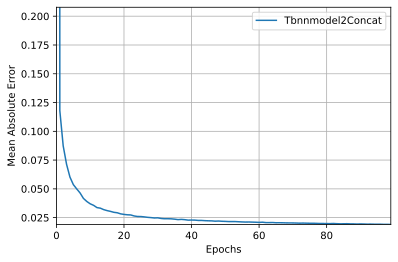

In [176]:
plot0 = HistoryPlotter(metric='mean_absolute_error')
plot0.plot(histories)
#plot0.plot(histories, yMax=10)
#plot0.plot(histories, yMax=3, log=True)

In [177]:
%%time
writePrediction(TBNNModel2Concat.predict([test_features_long[:sz], test_features_short[:sz]]), 'predT', times[0], sz)

1557/1557 [==============================] - 1s 659us/step
CPU times: user 1.83 s, sys: 182 ms, total: 2.01 s
Wall time: 1.7 s
